# Document preprocessing and embeddings
Steps :
1. Download the pdf
2. Spiltting the pages into sentences
3. Chunking the sentences into groups
4. Creating the sentence chunks
5. Filtering the chunks with more than certain limits
6. Embedding the chunks

In [47]:
# File management
import os
import requests
import re
import random

import fitz # PyMuPDF package
from tqdm import tqdm
from spacy.lang.en import English

import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer

## Download the pdf

In [8]:
def download_pdf(url : str,
                 filepath : str,
                 filename : str = "data.pdf"):
    """To download the file from the url"""
    
    file = filepath + filename

    if not os.path.exists(filepath):
        # There is no folder so we will create a folder 
        os.makedirs(filepath)
        print(f"[INFO] {filepath} is created successfully")
        
    if not os.path.exists(file):
        print(f"[INFO] {filename} is downloading ...")
        response = requests.get(url)

        if response.status_code == 200 :
            # Successfully got the pdf
            with open(file,"wb") as file:
                file.write(response.content)
            print(f"[INFO] {filename} sucessfully downloaded ...")
        else:
            # Failed to get the pdf
            print(f"[INFO] Failed to get the pdf from the url : {url}")
    else:
        print(f"[INFO] The {filename} pdf is already exists")

In [9]:
filename = "human-nutrition-text.pdf"
filepath = "docs/"
url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"
download_pdf(url,filepath,filename)

[INFO] human-nutrition-text.pdf is downloading ...
[INFO] human-nutrition-text.pdf sucessfully downloaded ...


## Convert PDF into dict

In [34]:
def text_formatter(text : str) -> str:
    """ Convert the text with /n with space"""
    formatted_text = text.replace('\n',' ').strip()

    return formatted_text

def count_and_split_sentence(text : str) -> (int , list[str]) :
    """To count and split the sentences from the given text"""
    nlp = English()
    nlp.add_pipe("sentencizer")

    list_of_sentences = list(nlp(text).sents)
    
    # list of sentences contains string datatypes
    list_of_sentences = [str(sentence) for sentence in list_of_sentences]
    
    return len(list_of_sentences),list_of_sentences

def open_pdf(filename : str,
             starting_page_number : int) -> list[dict]:
    """convert the pdf into dataset"""
    doc = fitz.open(filename)
    data = []

    for page_number , page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter( text = text )

        sentence_count,sentences = count_and_split_sentence(text)

        data.append({
            "page_number" : page_number - starting_page_number,
            "char_count" : len(text),
            "word_count" : len(text.split(" ")),
            "sentence_count" : sentence_count,
            "token_count" : len(text) / 4, # 1 word contains 4 tokens approx
            "sentence" : sentences,
            "text" : text
        })
    return data

In [35]:
pages_and_texts = open_pdf(filepath+filename,starting_page_number = 41)
len(pages_and_texts)

1208it [05:02,  3.99it/s]


1208

## Chunking the sentences

In [31]:
def split_the_array(array_list : list , chunk_length : int) -> list[list[str]]:
    """Splits the array of sentences into groups of chunks"""
    return [array_list[i:i+chunk_length] for i in range(0,len(array_list),chunk_length)]

In [30]:
split_the_array(list(range(25)),10)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [36]:
# creating chunks of sentences into chunks
chunk_size = 10

for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_the_array(item["sentence"],chunk_size)
    item["chunk_count"] = len(item["sentence_chunks"])

pages_and_chunks = []

for item in tqdm(pages_and_texts):
    for chunks in item["sentence_chunks"]:
        d = {}
        d["page_number"] = item["page_number"]

        joined_sentence = "".join(chunks).replace("  "," ").strip()
        joined_sentence = re.sub(r'\.([A-Z])', r'. \1',joined_sentence) # .A -> . A it is used to provide a space after a sentence ends

        d["sentence_chunk"] = joined_sentence
        # stats
        d["char_count"] = len(joined_sentence)
        d["word_count"] = len(list(joined_sentence.split(" ")))
        d["token_count"] = len(joined_sentence) / 4 # 4 tokens ~ 1 word

        pages_and_chunks.append(d)

100%|██████████| 1208/1208 [00:00<00:00, 16831.84it/s]


In [39]:
random.sample(pages_and_chunks,k=1)

[{'page_number': 995,
  'sentence_chunk': 'lead to symptoms that are also common to food infection, such as abdominal cramping, while others can cause different kinds of symptoms and complications, some very severe. For example, mercury, which is sometimes found in fish, can cause neurological damage in infants and children. Exposure to cadmium can cause kidney damage, typically in elderly people. Learning Activities Technology Note: The second edition of the Human Nutrition Open Educational Resource (OER) textbook features interactive learning activities. These activities are available in the web-based textbook and not available in the downloadable versions (EPUB, Digital PDF, Print_PDF, or Open Document). Learning activities may be used across various mobile devices, however, for the best user experience it is strongly recommended that users complete these activities using a desktop or laptop computer and in Google Chrome.  An interactive or media element has been excluded from this 

In [41]:
dataframe = pd.DataFrame(pages_and_chunks)
dataframe.head(1)

,page_number,sentence_chunk,char_count,word_count,token_count
0,-41,Human Nutrition: 2020 Edition,29,4,7.25


In [44]:
# Only selecting the token_count that has more than 30 length
chunk_lower_limit = 30
dataframe_above_token_length = dataframe[dataframe["token_count"] > chunk_lower_limit].to_dict(orient="records")

In [46]:
random.sample(dataframe_above_token_length,k=1)

[{'page_number': 1157,
  'sentence_chunk': 'Domain; “Bag of sugar” by Evilestmark / Public Domain; “Drink milk butterfly” by Glitch / Public Domain 10. Figure 4.5 Dietary Fiber reused “Apples” by gnokii / Public Domain; “Wheat kernel nutrition” by Jon C / CC BY-SA 3.0 11. Figure 4.8 The Regulation of Glucose reused “Pancreas organ” by Zachvanstone8 / CC0; “Liver” by Maritacovarrubias / Public Domain; “Muscle types” by Bruce Balus / CC BY-SA 4.0 12. Figure 4.9 Overview of Carbohydrate Digestion reused “Digestive system without labels” by Mariana Ruiz / Public Domain 13. Figure 5.1 Types of Lipids reused “Corn” by gnokii / Public Domain; “Cheese” by gnokii / Public Domain; “Drink milk butterfly” by Glitch / Public Domain; “Walnut” by Firkin / Public Domain; “Olive oil” by gnokii / Public Domain 14. Figure 5.10 Lipid Digestion and Absorption reused “Digestive system without labels” by Mariana Ruiz / Public Domain; “Simple columnar epithelial cells” by McortNGHH / CC BY 3.0 15. Figure 5.13

## Embedding the chunks

In [58]:
model_name = "all-mpnet-base-v2"
device = 'cuda'

def convert_to_embedds(model_name : str,
                       data : list[dict],
                       device : str):
    embedding_model = SentenceTransformer(model_name_or_path = model_name , device = device)

    for item in tqdm(data):
        item["embeddings"] = embedding_model.encode(item["sentence_chunk"] , convert_to_tensor = True)

In [59]:
%%time
convert_to_embedds(model_name,dataframe_above_token_length,device)

100%|██████████| 1680/1680 [01:16<00:00, 22.04it/s]

CPU times: total: 2min 43s
Wall time: 1min 21s


In [60]:
random.sample(dataframe_above_token_length,k=1)

[{'page_number': 493,
  'sentence_chunk': 'of body fatness responds to energy intake or energy expenditure, such that if a person is exposed to a greater amount of food, body fatness increases, or if a person watches more television body fatness increases. A major problem with these theories is that they overgeneralize and do not take into account that not all individuals respond in the same way to changes in food intake or energy expenditure. This brings up the importance of the interactions of genes and the environment. Not all individuals who take a weight-loss drug lose weight and not all people who smoke are thin. An explanation for these discrepancies is that each individual’s genes respond differently to a specific environment. Alternatively, environmental factors can influence a person’s gene profile, which is exemplified by the effects of the prenatal environment on body weight and fatness and disease incidence later in life.1 One example is a study of the offspring of women w

In [62]:
# Saving the embeddings
embeddings_file = "embeddings_file.csv"
dataframe = pd.DataFrame(dataframe_above_token_length)
dataframe.to_csv(embeddings_file,index=False)

# Retreival and Search
Steps:
1. Similarity search
2. Provide the pdf image to show the relevant details
3. Loading the LLM locally
4. Generate the text thorugh LLM
5. Augment user query and prompt
6. Preprocess the output 

In [32]:
# imports
import pandas as pd
import numpy as np
import torch
import numpy
import matplotlib.pyplot as plt

import textwrap
import fitz
from sentence_transformers import util,SentenceTransformer

from transformers import AutoTokenizer , AutoModelForCausalLM

## Similarity Search

In [29]:
PAGES_AND_CHUNKS = pd.read_csv("embeddings_file.csv").to_dict(orient='records')

def wrap_the_text(text : str,wrap_length : int = 100):
    """wrap_the_text prettify the text"""
    wrapped_text = textwrap.fill(text,wrap_length)
    print(wrapped_text)
    
def print_retrieved_text(query : str,
                         score,
                         index : int,
                         pages_and_chunks = PAGES_AND_CHUNKS):
    """Prints the retrieved texts"""
    print(f"Query : {query}")
    for score, index in zip(score,index):
        print(f"Score : {score}")
        print("The Text :")
        print(f"Index : {index}")
        wrap_the_text(pages_and_chunks[index]["sentence_chunk"])

def display_the_page(index : int , 
                     starting_page_count : int,
                     filename : str = "human-nutrition-text.pdf",
                     filepath : str = "docs/"):
    """Displays the content of the pdf in Image"""
    doc = fitz.open(filepath + filename)
    page = doc.load_page(index + starting_page_count) # as our pdf content starts from 41

    # convert page text into np.array
    img = page.get_pixmap(dpi=300)
    doc.close()
    img_array = np.frombuffer(img.samples_mv,dtype=np.uint8).reshape((img.h, img.w, img.n))

    # display the image by matplotlib
    plt.imshow(img_array)
    plt.axis("off")
    plt.show()

def retrieve_relevant_resource( user_query : str ,
                               embeddings, 
                               embedding_model, 
                               device,
                               k = 5,
                               to_print : bool = False,
                               to_display : bool = False):
    """Function to retrieve relevant resource"""
    
    query_embedding = embedding_model.encode(user_query, convert_to_tensor = True).to(device)

    dot_score = util.dot_score( a = query_embedding, b = embeddings)[0]
    score , idx = torch.topk(dot_score,k=k)

    if to_print:
        print_retrieved_text(user_query,score,idx)

    if to_display:
        for scores,index in zip(score,idx):
            print(f"Score : {scores}")
            print(f"Page number : {PAGES_AND_CHUNKS[index]['page_number']}")
            try :
                display_the_page(PAGES_AND_CHUNKS[index]['page_number'],41)
            except ValueError:
                pass
            
    return score,idx

In [3]:
user_query = "processed foods"
model_name = "all-mpnet-base-v2"
device = "cuda"
data_filename = "embeddings_file.csv"

data = pd.read_csv(data_filename)

embedding_model = SentenceTransformer(model_name_or_path = "all-mpnet-base-v2", device = device)

In [4]:
data_embeddings = []

for tensor_str in data["embeddings"]:
    values_str = tensor_str.split("[")[1].split("]")[0]
    values_list = [float(val) for val in values_str.split(",")]
    tensor_result = torch.tensor(values_list)
    data_embeddings.append(tensor_result)

data_embeddings = torch.stack(data_embeddings).to(device)
data_embeddings.shape

torch.Size([1680, 768])

In [6]:
data_embeddings.to("cuda")
retrieve_relevant_resource(
    user_query,
    data_embeddings, 
    embedding_model, 
    device,
    k = 5,
    to_print = False,
    to_display = False
)

(tensor([0.6357, 0.5949, 0.5776, 0.5539, 0.5416], device='cuda:0'),
 tensor([1458, 1457, 1448,  394, 1501], device='cuda:0'))

In [12]:
retrieve_relevant_resource(
    user_query,
    data_embeddings, 
    embedding_model, 
    device,
    k = 5,
    to_print = True,
    to_display = False
)

Query : processed foods
Score : 0.6357370615005493
The Text :
Index : 1458
creating products that have a much longer shelf life than raw foods. Also, food processing protects
the health of the consumer and allows for easier shipment and the marketing of foods by
corporations. However, there are certain drawbacks. Food processing can reduce the nutritional
content of raw ingredients. For example, canning involves the use of heat, which destroys the
vitamin C in canned fruit. Also, certain food additives that are included during processing, such as
high fructose corn syrup, can affect the health of a consumer. However, the level of added sugar can
make a major difference. Small amounts of added sugar and other sweeteners, about 6 to 9 teaspoons a
day or less, are not considered harmful.1 Food Additives If you examine the label for a processed
food product, it is not unusual to see a long list of added materials. These natural or synthetic
substances are food additives and there are more 

(tensor([0.6357, 0.5949, 0.5776, 0.5539, 0.5416], device='cuda:0'),
 tensor([1458, 1457, 1448,  394, 1501], device='cuda:0'))

Score : 0.6357370615005493
Page number : 1026


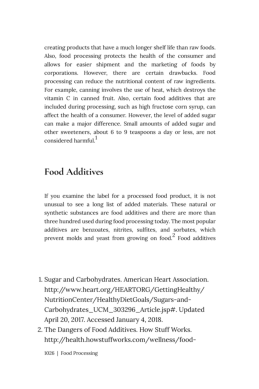

Score : 0.5948607921600342
Page number : 1025


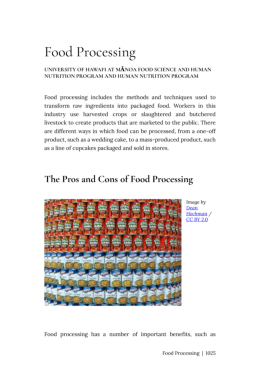

Score : 0.5776351690292358
Page number : 1018


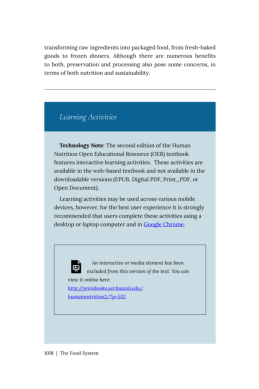

Score : 0.553895115852356
Page number : 262


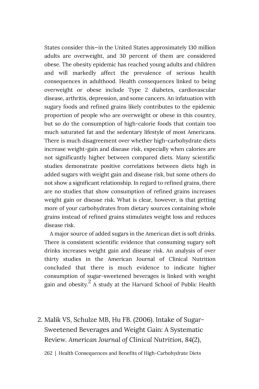

Score : 0.5416256785392761
Page number : 1056


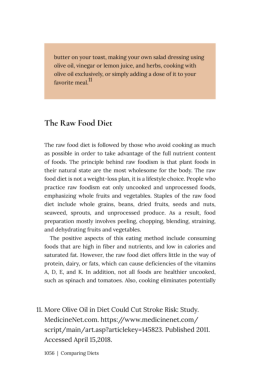

(tensor([0.6357, 0.5949, 0.5776, 0.5539, 0.5416], device='cuda:0'),
 tensor([1458, 1457, 1448,  394, 1501], device='cuda:0'))

In [30]:
retrieve_relevant_resource(
    user_query,
    data_embeddings, 
    embedding_model, 
    device,
    k = 5,
    to_print = False,
    to_display = True
)

## LLM

In [33]:
model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

# LLM
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16).to("cuda")

In [37]:
# to display the number of parameters ~ 1.1B
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

print(f" Parameters Count : {get_model_num_params(llm_model)}")

 Parameters Count : 1100048384


In [38]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 2215828224, 'model_mem_mb': 2113.18, 'model_mem_gb': 2.06}

## Prompt Engineering
In RAG , prompt engineering is also called as **augementing**

In [39]:
def prompt_formatter(query: str, 
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    base_prompt = """Based on the following context items, please answer the query.
Use the following example as reference for the ideal answer style.
\nExample :
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Update base prompt with context items and query   
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [43]:
%%time

query = "What is nutrition?"

# Get relevant resources
scores, indices = retrieve_relevant_resource(query,data_embeddings, embedding_model, device)
    
# Create a list of context items
context_items = [PAGES_AND_CHUNKS[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7,
                             max_new_tokens=256) 

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n")
output_text = output_text.split("<|assistant|>")
wrap_the_text(output_text[1])

E:\jai\apps\miniconda\envs\rag\Lib\site-packages\transformers\generation\configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
E:\jai\apps\miniconda\envs\rag\Lib\site-packages\transformers\models\llama\modeling_llama.py:671: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Query: What is nutrition?
RAG answer:

 The context item provides an example of the ideal answer style for the question "What is
nutrition?"  The passage states that nutrition is the science and art of providing the necessary
nutrients to maintain overall health and maintain overall health. It includes the six classes of
nutrients required for the body to function and maintain overall health, as well as the sixteen
essential minerals and thirteen vitamins. Nutrients are essential for building molecules into larger
macromolecules, and to turn macromolecules into organelles and cells, which then turn into tissues,
organs, and organ systems, and finally into an organism. Proper nutrition provides the necessary
nutrients to make energy that supports life's processes. The passage also discusses the importance
of research and scientific methods to understanding nutrition, as well as the importance of food
composition data and non-nutrient input energy. The passage concludes by stating that n